O primeiro passo é importar os dados que foram disponibilizados no Kaggle (Home Credit Stability Model Competition), por isso, utilizando a API do Kaggle, importaremos apenas os dados parquet (pois são mais leves).

In [1]:
#!kaggle competitions download -c home-credit-credit-risk-model-stability -p ../data/

In [2]:
# pega o diretório pai (projeto) e adiciona ao path
import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

import funcs.aux_utils as aux
import importlib
importlib.reload(aux)
from pathlib import Path
import gc

ZIP_PATH = Path("../data/home-credit-credit-risk-model-stability.zip")
DEST_DIR = Path("../data/pqt_files")
EXTENSION = ".parquet"
PREFIX = "train_"

In [3]:
aux.HandleData.unzip_files(
    path = ZIP_PATH,
    dest_dir = DEST_DIR,
    file_type = EXTENSION,
    prefix = PREFIX
)

Destino já existe e não está vazio; nada a fazer.


In [4]:
import pandas as pd
import numpy as np
import polars as pl


import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings

filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


pl.Config(
    **dict(
        tbl_formatting="ASCII_FULL_CONDENSED",
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
        fmt_float="mixed",
        tbl_cell_alignment="CENTER",
        tbl_hide_dtype_separator=True,
        tbl_cols=100,
        tbl_rows=None,
        fmt_str_lengths=100,
    )
)
os.environ["POLARS_MAX_THREADS"] = "4"

# Sobre os dados

Em decorrência da quantidade de tabelas e de colunas, será necessário a construção de um Pipeline e de uma classe auxiliar para lidar com esta quantidade massiva de dados.

A seguida, vamos definir como trataremos as demais tabelas do dataset. Portanto, para que o processo de leitura e EDA da tabela seja bem sucedido e de maneira eficaz, iremos aplicar algumas transformações nos dados. Para isso, seguiremos algumas premissas:

- Tabelas com depth > 1 (que representam medidas retiradas dos dados estáticos) serão agregadas (utilizando "case_id") a partir de alguns critérios, são eles:

    - Disclaimer: As colunas das tabelas com profundidade possuem identificadores em seus nomes, indicando qual tipo de transformações foram aplicadas nestas tabelas, são elas:
        1. **P** (Days over due - Dias em atraso): Medidas que envolvem datas de atrasos, proporções de datas e etc.
        2. **M** (Masking categorias - Categorias com máscaras): Categorias como genêro, status e outros dados categóricos
        3. **A** (Tranform Ammount - Transformações de quantidade): Quantidades numéricas que foram transformadas ou processadas seguindo alguma lógica
        4. **D** (Transform Date - Transformações de datas): Colunas que dizem a respeito sobre datas que foram adicionadas como informações relevantes 
        5. **T** e **L** (Unespecified Transform - Transformações não inespecificadas): Valores que não se encaixam em nenhuma das outras categorias e não possuem "tracking" de informações, entretanto, podem sinalizar informações relevantes ao modelo.

    - **Para colunas terminadas em P e A (dados numéricos)**: Será aplicado um casting de tipo e agregações por -> Valor máximo, último valor e média
    - **Para colunas terminadas em D**: Será aplicado casting para date e agregações por -> Valor máximo, última data e média
    - **Para colunas terminadas em M (Strings)**: Será aplicado um casting para "category" e posteriormente agregadas por -> Valor máximo (lexicograficamente o último) e o último valor
    - **Para outras colunas**: Definiremos agregações por -> Máximo e último valor 

Portanto para estes processos ocorrerem de forma harmoniosa e automatizada utilizaremos as classes definidas no pacote funcs.aux_utils.py com o intuito de aplicar tais transformações e ao final juntar todas as tabelas baseado no "case_id".

In [5]:
base = pl.read_parquet(f'{DEST_DIR}/base.parquet')

files = list(DEST_DIR.glob("*.parquet"))
optimized_tables = {
    f.stem: aux.HandleData.read_file(f)
    for f in files if f != "base"
}

Descartando colunas com >70% de missing: ['byoccupationinc_3656910L', 'credacc_actualbalance_314A', 'credacc_maxhisbal_375A', 'credacc_minhisbal_90A', 'credacc_status_367L', 'credacc_transactions_402L', 'dtlastpmt_581D', 'isdebitcard_527L', 'revolvingaccount_394A']
Descartando colunas com >70% de missing: ['byoccupationinc_3656910L', 'credacc_actualbalance_314A', 'credacc_maxhisbal_375A', 'credacc_minhisbal_90A', 'credacc_status_367L', 'credacc_transactions_402L', 'dtlastpmt_581D', 'isdebitcard_527L', 'revolvingaccount_394A']
Descartando colunas com >70% de missing: ['credacc_cards_status_52L']
Descartando colunas com >70% de missing: ['annualeffectiverate_199L', 'annualeffectiverate_63L', 'contractsum_5085717L', 'credlmt_230A', 'credlmt_935A', 'dateofcredend_289D', 'dateofcredend_353D', 'dateofcredstart_181D', 'dateofcredstart_739D', 'dateofrealrepmt_138D', 'debtoutstand_525A', 'debtoverdue_47A', 'dpdmax_139P', 'dpdmax_757P', 'dpdmaxdatemonth_442T', 'dpdmaxdatemonth_89T', 'dpdmaxdatey

In [6]:
optimized_tables.keys()

dict_keys(['applprev_1_0', 'applprev_1_1', 'applprev_2', 'base', 'credit_bureau_a_1_0', 'credit_bureau_a_1_1', 'credit_bureau_a_1_2', 'credit_bureau_a_1_3', 'credit_bureau_a_2_0', 'credit_bureau_a_2_1', 'credit_bureau_a_2_10', 'credit_bureau_a_2_2', 'credit_bureau_a_2_3', 'credit_bureau_a_2_4', 'credit_bureau_a_2_5', 'credit_bureau_a_2_6', 'credit_bureau_a_2_7', 'credit_bureau_a_2_8', 'credit_bureau_a_2_9', 'credit_bureau_b_1', 'credit_bureau_b_2', 'debitcard_1', 'deposit_1', 'other_1', 'person_1', 'person_2', 'static_0_0', 'static_0_1', 'static_cb_0', 'tax_registry_a_1', 'tax_registry_b_1', 'tax_registry_c_1'])

In [7]:
del optimized_tables["base"]

In [8]:

aggregated = {}
keys = list(optimized_tables.keys())
for name in keys:
    df = optimized_tables[name]
    print(f"🔄 Aggregating {name} ({df.height:,} rows)…")
    aggregated[name] = aux.Aggregator.aggregate(df)

    optimized_tables.pop(name)
    gc.collect()

print("✅ Agregação concluída")

🔄 Aggregating applprev_1_0 (3,887,684 rows)…
🔄 Aggregating applprev_1_1 (2,638,295 rows)…
🔄 Aggregating applprev_2 (14,075,487 rows)…
🔄 Aggregating credit_bureau_a_1_0 (4,108,212 rows)…
🔄 Aggregating credit_bureau_a_1_1 (6,009,192 rows)…
🔄 Aggregating credit_bureau_a_1_2 (3,743,810 rows)…
🔄 Aggregating credit_bureau_a_1_3 (2,079,323 rows)…
🔄 Aggregating credit_bureau_a_2_0 (5,296,031 rows)…
🔄 Aggregating credit_bureau_a_2_1 (7,861,809 rows)…
🔄 Aggregating credit_bureau_a_2_10 (4,386,062 rows)…
🔄 Aggregating credit_bureau_a_2_2 (17,893,536 rows)…
🔄 Aggregating credit_bureau_a_2_3 (26,563,901 rows)…
🔄 Aggregating credit_bureau_a_2_4 (27,025,737 rows)…
🔄 Aggregating credit_bureau_a_2_5 (33,053,760 rows)…
🔄 Aggregating credit_bureau_a_2_6 (25,511,332 rows)…
🔄 Aggregating credit_bureau_a_2_7 (8,055,986 rows)…
🔄 Aggregating credit_bureau_a_2_8 (13,927,071 rows)…
🔄 Aggregating credit_bureau_a_2_9 (18,723,227 rows)…
🔄 Aggregating credit_bureau_b_1 (85,791 rows)…
🔄 Aggregating credit_bureau_b_2

In [9]:
final = aux.HandleData.merge_tables(
    base   = base,
    tables = aggregated,
    on     = "case_id",
    how    = "left"
)


print(final.shape)

(1526659, 1598)


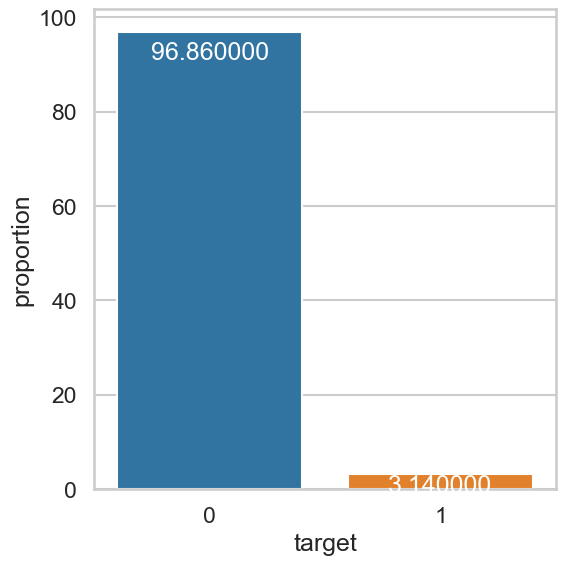

Proporção do target
Clientes não inadimplentes (em %): 3.14
Clientes não inadimplentes (em %): 96.86


In [10]:
chart_maker = aux.ChartMaker(figure_size=(6, 6))

count_target = final['target'].value_counts(normalize=True)
count_target = count_target.with_columns([
    (pl.col('proportion') * 100).round(2).alias('proportion')
])

chart_maker.plot_bar_chart(X=count_target['target'], y=count_target['proportion'])

print('Proporção do target')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][0]}')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][1]}')

del chart_maker

Podemos ver que a classe alvo é bastante desbalanceada, tendo cerca de apenas 3,1% dos clientes inadimplementes. Denota-se então a necessidade da aplicação e cuidado de técnicas de modo a não enviesar o modelo e causar um overfit a respeito do conjunto de treinamento. Dessa forma, para garantir que o processo de EDA e de criação do modelo esteja seguro de vazamento de dados, separaremos o conjunto de dados em: 

    1. Treino
    2. Validação
    3. Teste

Utilizaremos a função train_test_split do scikit-learn com o parâmetro "stratify" aplicado em virtude do desbalanceamento do target.

In [11]:
from sklearn.model_selection import train_test_split

X = final.drop(['target', 'WEEK_NUM'])
y = final['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

print(f'Shape do conjunto de variáveis preditoras de treinamento: {X_train.shape} | proporção: {X_train.shape[0] / final.shape[0] * 100:.2f}')
print(f'Shape do conjunto de variáveis preditoras de validação: {X_val.shape} | proporção: {X_val.shape[0] / final.shape[0] * 100:.2f} ')
print(f'Shape do conjunto de variáveis preditoras de teste: {X_test.shape} | proporção: {X_test.shape[0] / final.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de treinamento: {y_train.shape} | proporção: {y_train.shape[0] / final.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de validação: {y_val.shape} | proporção: {y_val.shape[0] / final.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de test: {y_test.shape} | proporção: {y_test.shape[0] / final.shape[0] * 100:.2f} ')

train = X_train.with_columns(y_train)
val = X_val.with_columns(y_val)
test = X_test.with_columns(y_test)

Shape do conjunto de variáveis preditoras de treinamento: (915995, 1596) | proporção: 60.00
Shape do conjunto de variáveis preditoras de validação: (305332, 1596) | proporção: 20.00 
Shape do conjunto de variáveis preditoras de teste: (305332, 1596) | proporção: 20.00 
Shape da variável alvo de treinamento: (915995,) | proporção: 60.00 
Shape da variável alvo de validação: (305332,) | proporção: 20.00 
Shape da variável alvo de test: (305332,) | proporção: 20.00 


Separados em seus respectivos conjuntos, vamos avaliar quantos valores missing o conjunto de treino possui. Além disso, vamos separar amostras estratificadas com a variável alvo em decorrência da quantidade de dados presentes neste conjunto de treinamento. Essas amostras serão utilizadas para a realizar a feature selection, eliminando colunas que estejam com alta correlação. Além disso, classificaremos as features mais importantes durante este processo.


In [12]:
rows = train.shape[0]

rows = train.shape[0]
missings = []

for col in train.columns:
    cnt = train[col].null_count()
    pct = cnt / rows * 100
    missings.append({
        "column": col,
        "null_count": cnt,
        "null_pct": pct
    })

missings = pd.DataFrame(missings)

above_30 = missings["null_pct"] > 30
above_40 = missings["null_pct"] > 40
above_50 = missings["null_pct"] > 50
above_60 = missings["null_pct"] > 60
above_70 = missings["null_pct"] > 70


print("Features com >30% missing:", above_30.sum())
print("Features com >40% missing:", above_40.sum())
print("Features com >50% missing:", above_50.sum())
print("Features com >60% missing:", above_60.sum())
print("Features com >60% missing:", above_70.sum())

Features com >30% missing: 1514
Features com >40% missing: 1378
Features com >50% missing: 1285
Features com >60% missing: 1176
Features com >60% missing: 924


Bom, observamos a presença de várias features com bastante missings, um ponto importante é que estas colunas podem vir a prejudicar o desempenho do modelo ou a capacidade computacional. Devido ao alto valor de missings, iremos "dropar" as colunas que possuírem mais de 40% de missings.

In [13]:
cols_to_drop = missings.loc[missings["null_pct"] >= 40, "column"].tolist()

train_reduced = train.drop(cols_to_drop)

val_reduced = val.drop(cols_to_drop)

test_reduced = test.drop(cols_to_drop)

train_reduced.shape, val_reduced.shape, test_reduced.shape

((915995, 219), (305332, 219), (305332, 219))

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import re

In [15]:
X_train = train.drop(['target', 'case_id'])
y_train = train['target']

X_val = val.drop(['target', 'case_id'])
y_val = val['target']

X_test = test.drop(['target', 'case_id'])
y_test = test.drop(['target', 'case_id'])

schema = X.schema

In [16]:
pattern = re.compile(r".+_[0-9]+([PAMLT])_.*")

num_prefixes = ("Int", "UInt", "Float", "Decimal")

codes = ["P", "A", "M", "L", "T", "other"]

In [17]:
num_feats = []
cat_feats = []

for col, dtype in schema.items():
    if col in ("case_id", "target"):
        continue
    m = pattern.match(col)
    code = m.group(1) if m else "other"
    if any(str(dtype).startswith(pref) for pref in num_prefixes):
        num_feats.append(col)
    else:
        cat_feats.append(col)

num_feats, cat_feats

(['actualdpd_943P_max',
  'actualdpd_943P_last',
  'actualdpd_943P_mean',
  'annuity_853A_max',
  'annuity_853A_last',
  'annuity_853A_mean',
  'credacc_credlmt_575A_max',
  'credacc_credlmt_575A_last',
  'credacc_credlmt_575A_mean',
  'credamount_590A_max',
  'credamount_590A_last',
  'credamount_590A_mean',
  'currdebt_94A_max',
  'currdebt_94A_last',
  'currdebt_94A_mean',
  'downpmt_134A_max',
  'downpmt_134A_last',
  'downpmt_134A_mean',
  'mainoccupationinc_437A_max',
  'mainoccupationinc_437A_last',
  'mainoccupationinc_437A_mean',
  'maxdpdtolerance_577P_max',
  'maxdpdtolerance_577P_last',
  'maxdpdtolerance_577P_mean',
  'outstandingdebt_522A_max',
  'outstandingdebt_522A_last',
  'outstandingdebt_522A_mean',
  'childnum_21L_lexmax',
  'childnum_21L_last',
  'pmtnum_8L_lexmax',
  'pmtnum_8L_last',
  'tenor_203L_lexmax',
  'tenor_203L_last',
  'actualdpd_943P_max_applprev_1_1',
  'actualdpd_943P_last_applprev_1_1',
  'actualdpd_943P_mean_applprev_1_1',
  'annuity_853A_max_appl

In [18]:
num_pipe = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', LabelEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num_transformer', num_pipe, num_feats),
    ('cat_transformer', cat_pipe, cat_feats)
])

In [19]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, class_weight="balanced", random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, n_jobs=-1, class_weight="balanced", random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=500, learning_rate=0.05,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500, learning_rate=0.05,
        random_seed=42, verbose=False,
        thread_count=-1, class_weights=[1, 1]
    )
}

In [ ]:
cat_boost = aux.ModelUtils.make_model(preprocessor, models['CatBoost'], X_train=X_train, X_test=X_val, y_train=y_train, y_test=y_val)